# Import

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score,
                           f1_score, matthews_corrcoef, make_scorer)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

# Functions 

## Utility Functions

In [4]:
def count_outliers(s, k_inner=1.5, k_outer=3):
    """
    Counts the number of outliers in a sample using both inner and outer fences.
    
    Parameters
    ----------
    s : numpy 1D array or Series
        Sample where Tukey's fences method is applied.
        
    k_inner : float, default 1.5
        Factor to determine the inner fence.
        
    k_outer : float, default 3
        Factor to determine the outer fence.
        
    Returns
    -------
    inner_outliers : int
        Number of inner outliers in the sample.
    
    outer_outliers : int
        Number of outer outliers in the sample.
    """
    
    # Calculating inner fences
    IQR = np.quantile(s, .75) - np.quantile(s, .25)
    lower_inner_fence = np.quantile(s, .25) - k_inner * IQR
    upper_inner_fence = np.quantile(s, .75) + k_inner * IQR

    # Calculating outer fences
    lower_outer_fence = np.quantile(s, .25) - k_outer * IQR
    upper_outer_fence = np.quantile(s, .75) + k_outer * IQR

    # Counting inner and outer outliers
    inner_outliers = np.sum((s < lower_inner_fence) | (s > upper_inner_fence))
    outer_outliers = np.sum((s < lower_outer_fence) | (s > upper_outer_fence))
    
    return inner_outliers, outer_outliers

## Visualization Functions

In [5]:
def classification_plot(y_test_clf, predictions, model_name, driver_name):
    """
    Create and display a confusion matrix heatmap.
    
    Args:
        y_test_clf: True labels
        predictions: Predicted labels
        model_name (str): Name of the model
        driver_name (str): Name of the driver gene
    """
    cm = confusion_matrix(y_test_clf, predictions)
    labels = ['Positive', 'Negative']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model_name} - {driver_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Evaluation Functions

In [6]:
def classification_evaluation(y_test_clf, predictions):
    """
    Calculate various classification metrics.
    
    Args:
        y_test_clf: True labels
        predictions: Predicted labels
    
    Returns:
        pd.DataFrame: DataFrame containing evaluation metrics
    """
    metrics = {
        'Test Accuracy': [accuracy_score(y_test_clf, predictions)],
        'Test Precision': [precision_score(y_test_clf, predictions)],
        'Test Recall': [recall_score(y_test_clf, predictions)],
        'Test F1': [f1_score(y_test_clf, predictions)],
        'Test MCC': [matthews_corrcoef(y_test_clf, predictions)]
    }
    return pd.DataFrame(metrics)

def classification_scores(classifier_name, classifier, parameters, X_train, y_train, metric="f1"):
    """
    Perform grid search CV and return best model and scores.
    
    Args:
        classifier_name (str): Name of the classifier
        classifier: Classifier object
        parameters (dict): Parameters for grid search
        X_train: Training features
        y_train: Training labels
        metric (str): Scoring metric to optimize
    
    Returns:
        tuple: (best_estimator, evaluation_df, best_parameters)
    """
    mcc_scorer = make_scorer(matthews_corrcoef)
    cv = 5
    
    gs = GridSearchCV(
        classifier, 
        parameters, 
        cv=cv, 
        scoring=mcc_scorer if metric == "mcc" else metric, 
        n_jobs=-1
    )
    
    gs.fit(X_train, y_train)
    
    # Calculate cross-validation scores
    scorers = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'mcc': make_scorer(matthews_corrcoef)
    }
    
    scores = cross_validate(gs.best_estimator_, X_train, y_train, 
                          cv=cv, scoring=scorers, n_jobs=-1)
    
    # Evaluate the best model using cross-validation
    eval_df = pd.DataFrame({
        'Model': [classifier_name],
        'CV Accuracy': [np.mean(scores['test_accuracy'])],
        'CV Precision': [np.mean(scores['test_precision'])],
        'CV Recall': [np.mean(scores['test_recall'])],
        'CV F1': [np.mean(scores['test_f1'])],
        'CV MCC': [np.mean(scores['test_mcc'])]
    })
    
    return gs.best_estimator_, eval_df, gs.best_params_

def evaluate_models(driver, preprocessed_data, models_and_params):
    """
    Evaluates the provided models on the preprocessed data and stores the results.

    Parameters:
    driver (str): The name of the driver being processed.
    preprocessed_data (dict): The preprocessed data returned from preprocess_data function.
    models_and_params (dict): A dictionary of models and their hyperparameter grids.

    Returns:
    dict: A dictionary containing the evaluation results for each model.
    """
    results = {}
    X_train_resampled = preprocessed_data['X_train_resampled']
    y_train_resampled = preprocessed_data['y_train_resampled']
    X_test_scaled = preprocessed_data['X_test_scaled']
    y_test = preprocessed_data['y_test']
    
    for model_name, (model, params) in models_and_params.items():
        print(f"\nEvaluating model: {model_name} for driver: {driver}")
        
        # Suprimir warnings de convergência durante a validação cruzada e treinamento
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            
            best_model, eval_df, best_params = classification_scores(
                model_name, model, params, X_train_resampled, y_train_resampled, metric="f1"
            )
        
        print("Best Hyperparameters:", best_params)
        print(eval_df)

        # Predict on the test set
        y_pred = best_model.predict(X_test_scaled)
        
        # Generate and display the classification report
        print(f"Classification Report for {model_name} on driver {driver}:")
        print(classification_report(y_test, y_pred))

        # Plot the confusion matrix with model and driver names
        classification_plot(y_test, y_pred, model_name, driver)

        # Calculate additional evaluation metrics
        evaluation_results = classification_evaluation(y_test, y_pred)
        print("Additional Evaluation Metrics:")
        print(evaluation_results)

        # Store the results for this model and driver combination
        results[model_name] = {
            'Best_Model': best_model,
            'Evaluation_Results': evaluation_results,
            'Best_Params': best_params
        }

    return results


## Data Preprocessing

In [7]:
def check_dir(dir: str):
    """
    Creates a given path driectory "dir" if it does not exist.
    Args:
        dir (str): Path to the directory. 
    """
    if os.path.exists(dir) and os.path.isdir(dir):
        pass
    else:
        os.makedirs(dir)
        
def drivergroups(x):
    """
    Categorize a driver based on its positive and negative interactions.

    Args:
        x (pandas.Series): A row from a DataFrame containing the following columns:
            - n_dints: Total number of significant interactions for the driver
            - neg_dints: Number of negative interactions for the driver
            - pos_dints: Number of positive interactions for the driver
            
    Returns:
        str: The category of the driver based on its interaction profile:
            - "non_sign": The driver has no significant interactions
            - "pos": The driver has only positive interactions
            - "neg": The driver has only negative interactions
            - "more_neg": The driver has more negative interactions than positive
            - "more_pos": The driver has more positive interactions than negative
            - "neutral": The driver has a balanced number of positive and negative interactions
    """
    if x.n_dints == 0:
        return "non_sign"
    else:
        if x.neg_dints == 0:
            return "pos"
        elif x.pos_dints == 0:
            return "neg"
        else:
            if x.neg_dints > x.pos_dints:
                return "more_neg"
            elif x.pos_dints > x.neg_dints:
                return "more_pos"
            else:
                return "neutral"

def labeldrivers(
    df: pd.DataFrame,
    output=None
):
    """
    Categorize all drivers in a DataFrame using the `drivergroups` function.

    Args:
        df (pandas.DataFrame): A DataFrame containing the necessary columns for the `drivergroups` function.
        output (list, optional): A list to store the categorized driver labels. Defaults to an empty list.

    Returns:
        list: A list of categorized driver labels.
    """
    if output is None:
        output = []

    if len(output) == len(df):
        return output
    else:
        x = df.iloc[len(output)]
        return labeldrivers(df, output=output+[drivergroups(x)])

def preprocess_data(combined_df):
    """
    Preprocesses the input dataframe by scaling the data and handling class imbalance.

    Parameters:
    combined_df (pd.DataFrame): The combined dataframe with features and labels.

    Returns:
    dict: A dictionary containing the processed training and testing data.
    """
    # Prepare the data
    X = combined_df.drop(columns=['mutated', 'cancer_type'])
    y = combined_df['mutated'].astype(int)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    # Scale the data
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle class imbalance using SMOTEENN
    smote = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Return the processed data
    return {
        'X_train_resampled': X_train_resampled,
        'y_train_resampled': y_train_resampled,
        'X_test_scaled': X_test_scaled,
        'y_test': y_test
    }

# Load and Preprocess Data

In [8]:
datadir = "data/"
check_dir(datadir)

In [9]:
mutationtab = pd.read_feather(datadir+"mutation.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(mutationtab.shape)
display(mutationtab.head(2))
neighbourtab = pd.read_feather(datadir+"neighbours.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(neighbourtab.shape)
display(neighbourtab.head(2))

(8404, 2570)


,,A1CF,A2ML1,ABCA10,ABCA13,ABCA7,ABCB1,ABCB5,ABCC3,ABCC5,ABCC9,...,ZPBP2,ZRANB3,ZRSR2,ZSCAN31,ZSCAN4,ZSWIM3,ZSWIM6,ZWILCH,ZWINT,ZZEF1
patient,cancer_type,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,GBM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0055,GBM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(15206, 2570)


driver,A1CF,A2ML1,ABCA10,ABCA13,ABCA7,ABCB1,ABCB5,ABCC3,ABCC5,ABCC9,...,ZPBP2,ZRANB3,ZRSR2,ZSCAN31,ZSCAN4,ZSWIM3,ZSWIM6,ZWILCH,ZWINT,ZZEF1
neighbour,,,,,,,,,,,,,,,,,,,,,
A1BG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A1CF,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
tumourexp = pd.read_feather(datadir+"tumour_expression.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(tumourexp.shape)
display(tumourexp.head(2))
normalexp = pd.read_feather(datadir+"normal_expression.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(normalexp.shape)
display(normalexp.head(2))

(8404, 15206)


,,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAT,AAGAB,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
patient,cancer_type,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,GBM,6.98,0.0,15.05,5.40,5.22,1.16,8.87,8.92,7.87,10.01,...,8.03,8.66,6.05,8.48,10.12,0.69,10.24,11.92,10.45,9.24
TCGA-02-0055,GBM,8.62,0.0,15.39,1.42,8.93,0.64,9.22,8.31,6.66,10.41,...,8.87,7.95,5.45,8.14,9.25,2.60,9.85,13.49,9.25,9.49


(665, 15206)


,,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAT,AAGAB,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
patient,cancer_type,,,,,,,,,,,,,,,,,,,,,
TCGA-22-4593,LUSC,5.66,0.0,17.08,0.00,8.60,1.62,9.13,9.96,7.28,9.97,...,7.60,7.19,5.22,8.32,9.63,0.83,9.89,12.92,10.51,8.83
TCGA-22-4609,LUSC,6.12,0.0,16.80,2.28,8.59,0.76,8.83,9.60,6.89,9.41,...,7.29,5.59,6.04,9.02,10.24,1.03,9.87,12.66,11.12,9.19


In [11]:
results = pd.read_csv(datadir + "results.csv")
print("# of interactions in maingraph:", len(results))
print("# of drivers in maingraph:", results.driver.nunique())
print("# of neighbours in maingraph:", results.neighbour.nunique())
results.dropna(inplace=True)
print("# of interactions with results:", len(results))
print("# of drivers with results:", results.driver.nunique())
print("# of neighbours with results:", results.neighbour.nunique())

# of interactions in maingraph: 383337
# of drivers in maingraph: 2570
# of neighbours in maingraph: 15206
# of interactions with results: 361705
# of drivers with results: 2565
# of neighbours with results: 13064


In [12]:
dints = pd.read_csv(datadir + "DINTs.csv")
print(len(dints))  # Number of significant interactions after the initial filter

14197


In [13]:
n_neighbours = results.groupby(["driver"]).size().rename("n_neighbours")
alldints = dints[["driver", "neighbour"]].assign(significant=[1]*len(dints))
drivers = (
    results[["driver", "neighbour"]]
    # add signal column
    .assign(signal=results.coef/results.coef.abs())
    # add significant column
    .merge(alldints, how="left")
    # fill non significant interactions with 0
    .fillna(0)
    .drop(columns="neighbour")
    # compute number of positive and negative DINTs by driver
    .groupby(["driver", "signal"], as_index=False).sum()
    # add total number of interactions by driver
    .merge(n_neighbours, left_on="driver", right_index=True)
    # calculate percentage of positive and negative DINTs per driver
    .pivot(index=["driver", "n_neighbours"], columns="signal",
           values="significant")
    # fill 0 in drivers that have neighbours with only one signal
    .fillna(0).astype(int)
    .rename(columns={1: "pos_dints", -1: "neg_dints"})
    .reset_index().rename_axis(None, axis=1)
    .assign(
        n_dints=lambda x: x.neg_dints+x.pos_dints,
        neg_pct=lambda x: x.neg_dints/x.n_neighbours,
        pos_pct=lambda x: x.pos_dints/x.n_neighbours,
    )
    .fillna(0)
)
drivers = drivers.assign(group=labeldrivers(drivers))

filt_drivers = drivers.copy()
filt_drivers.loc[(filt_drivers.n_dints == 1), "group"] = "non_sign"
filt_drivers

,driver,n_neighbours,neg_dints,pos_dints,n_dints,neg_pct,pos_pct,group
0,A1CF,39,0,0,0,0.000000,0.000000,non_sign
1,A2ML1,91,3,4,7,0.032967,0.043956,more_pos
2,ABCA10,5,0,0,0,0.000000,0.000000,non_sign
3,ABCA13,9,1,3,4,0.111111,0.333333,more_pos
4,ABCA7,16,0,0,0,0.000000,0.000000,non_sign
...,...,...,...,...,...,...,...,...
2560,ZSWIM3,6,0,0,0,0.000000,0.000000,non_sign
2561,ZSWIM6,22,0,0,0,0.000000,0.000000,non_sign
2562,ZWILCH,22,0,1,1,0.000000,0.045455,non_sign
2563,ZWINT,136,0,22,22,0.000000,0.161765,pos


In [14]:
drivers_sig = drivers[drivers['group'] != 'non_sign']
drivers_sig

,driver,n_neighbours,neg_dints,pos_dints,n_dints,neg_pct,pos_pct,group
1,A2ML1,91,3,4,7,0.032967,0.043956,more_pos
3,ABCA13,9,1,3,4,0.111111,0.333333,more_pos
5,ABCB1,76,0,2,2,0.000000,0.026316,pos
7,ABCC3,26,0,1,1,0.000000,0.038462,pos
8,ABCC5,37,2,2,4,0.054054,0.054054,neutral
...,...,...,...,...,...,...,...,...
2553,ZNF99,3,0,1,1,0.000000,0.333333,pos
2556,ZRANB3,22,0,3,3,0.000000,0.136364,pos
2562,ZWILCH,22,0,1,1,0.000000,0.045455,pos
2563,ZWINT,136,0,22,22,0.000000,0.161765,pos


In [15]:
mutationtab = mutationtab.reset_index()
tumourexp = tumourexp.reset_index()

## Identify Significant Drivers

Identify driver genes that exhibit a balanced mutation profile and have strong connectivity within the gene interaction network, as these characteristics could potentially improve the predictive power of the models.

In [16]:
# Create a dictionary to make it easier to find ‘n_neighbours’ for each driver
neighbour_count_dict = drivers_sig.set_index('driver')['n_neighbours'].to_dict()

# Count mutations by driver and cancer type
mutation_counts = {}
cancer_types = mutationtab['cancer_type'].unique()

for driver in mutationtab.columns[2:]:
    mutation_counts[driver] = {}
    driver_series = mutationtab[driver]
    
    for cancer_type in cancer_types:
        cancer_filter = mutationtab['cancer_type'] == cancer_type
        ones_count = np.sum(driver_series[cancer_filter] == 1)
        zeros_count = np.sum(driver_series[cancer_filter] == 0)
        mutation_counts[driver][cancer_type] = {'ones': ones_count, 'zeros': zeros_count}

# Find the most common type of cancer and calculate the balance for each driver
driver_balance = {}

for driver, counts in mutation_counts.items():
    if counts:
        total_ones = sum(cancer['ones'] for cancer in counts.values())
        total_zeros = sum(cancer['zeros'] for cancer in counts.values())
        
        most_frequent_cancer = max(counts, key=lambda x: counts[x]['ones'] + counts[x]['zeros'])
        # Calculate the ratio of ones to total mutations for the most frequent cancer
        ones_ratio = counts[most_frequent_cancer]['ones'] / (counts[most_frequent_cancer]['ones'] + counts[most_frequent_cancer]['zeros'])
        
        if 0.1 <= ones_ratio <= 0.9:
            balance_score = 1 - abs(0.5 - ones_ratio)
            total_ratio = total_ones / (total_ones + total_zeros) if (total_ones + total_zeros) > 0 else 0
            
            driver_balance[driver] = {
                'Neighbour_Count': neighbour_count_dict.get(driver, 0),  
                'Most_Frequent_Cancer': most_frequent_cancer,
                'Balance_Score': balance_score,
                'Ones_Ratio': ones_ratio,
                'Total_Ones_Ratio': total_ratio,
                'Ones_Count': counts[most_frequent_cancer]['ones'],
                'Zeros_Count': counts[most_frequent_cancer]['zeros'],
                'Total_Ones': total_ones,
                'Total_Zeros': total_zeros
            }

# Final data frame
final_df = pd.DataFrame.from_dict(driver_balance, orient='index').reset_index().rename(columns={'index': 'Driver'})

# Sort the final date frame by the final score (descending)
final_df = final_df.sort_values(['Balance_Score', 'Neighbour_Count'], ascending=[False, False])

# Select the drivers with the best balance and the highest number of neighbours
selected_drivers = final_df.head(5)['Driver'].tolist()

# Filter the neighbours of the selected drivers
driver_neighbours = dints[dints['driver'].isin(selected_drivers)]

# Get the most frequent type of cancer for each driver from final_df
most_frequent_cancers = final_df.set_index('Driver')['Most_Frequent_Cancer'].to_dict()

# Filtering gene expression data in tumourexp
driver_combined_dfs = {}

for driver in selected_drivers:
    neighbours = driver_neighbours[driver_neighbours['driver'] == driver]['neighbour'].tolist()
    cancer_type = most_frequent_cancers[driver]
    
    # Filter individuals with the most frequent type of cancer and select relevant columns
    filtered_tumourexp = tumourexp[tumourexp['cancer_type'] == cancer_type]
    relevant_columns = ['cancer_type'] + neighbours
    combined_df = filtered_tumourexp[relevant_columns].copy()
    combined_df['mutated'] = mutationtab.loc[filtered_tumourexp.index, driver]
    
    driver_combined_dfs[driver] = combined_df


In [17]:
final_df

,Driver,Neighbour_Count,Most_Frequent_Cancer,Balance_Score,Ones_Ratio,Total_Ones_Ratio,Ones_Count,Zeros_Count,Total_Ones,Total_Zeros
2,PIK3CA,487,BRCA,0.846008,0.346008,0.136245,273,516,1145,7259
3,TP53,2259,BRCA,0.834601,0.334601,0.365778,264,525,3074,5330
0,CDH1,891,BRCA,0.629278,0.129278,0.028558,102,687,240,8164
1,GATA3,215,BRCA,0.621673,0.121673,0.024631,96,693,207,8197


In [18]:
# Add 'N_Individuals' as the sum of Ones_Count and Zeros_Count
new_final_df = final_df.copy()
new_final_df['N_Individuals'] = new_final_df['Ones_Count'] + new_final_df['Zeros_Count']

# Add '%MutationCases' as the percentage of Ones_Count over N_Individuals
new_final_df['%MutationCases'] = (new_final_df['Ones_Count'] / new_final_df['N_Individuals']) * 100

# Reorder the columns
new_final_df = new_final_df[['Driver', 'Neighbour_Count', 'Most_Frequent_Cancer', 'N_Individuals', '%MutationCases']]

In [19]:
new_final_df

,Driver,Neighbour_Count,Most_Frequent_Cancer,N_Individuals,%MutationCases
2,PIK3CA,487,BRCA,789,34.600760
3,TP53,2259,BRCA,789,33.460076
0,CDH1,891,BRCA,789,12.927757
1,GATA3,215,BRCA,789,12.167300


# Detect and Analyze Outliers

In [20]:
# Count and display outliers for each driver
for driver, combined_df in driver_combined_dfs.items():
    print(f"\nProcessing outliers for the driver: {driver}")
    inner_outliers_dict = {}
    outer_outliers_dict = {}
    ignore_columns = ['mutated', 'cancer_type']
    
    for column in combined_df.columns:
        if column not in ignore_columns:
            inner_outliers, outer_outliers = count_outliers(combined_df[column])
            inner_outliers_dict[column] = inner_outliers
            outer_outliers_dict[column] = outer_outliers
    
    inner_outliers_df = pd.DataFrame([inner_outliers_dict])
    outer_outliers_df = pd.DataFrame([outer_outliers_dict])
     
    print(f"Results for {driver}:")
    print("Inner Outliers:\n", inner_outliers_df)
    print("Outer Outliers:\n", outer_outliers_df)
    print("\n" + "="*50)

# Filter columns with outliers
for driver, combined_df in driver_combined_dfs.items():
    inner_outliers_dict = {}
    outer_outliers_dict = {}
    
    for column in combined_df.columns:
        if column not in ignore_columns:
            inner_outliers, outer_outliers = count_outliers(combined_df[column])
            inner_outliers_dict[column] = inner_outliers
            outer_outliers_dict[column] = outer_outliers
    
    inner_outliers_df = pd.DataFrame([inner_outliers_dict])
    outer_outliers_df = pd.DataFrame([outer_outliers_dict])
    
    inner_outliers_filtered = inner_outliers_df.loc[:, (inner_outliers_df > 0).any(axis=0)]
    outer_outliers_filtered = outer_outliers_df.loc[:, (outer_outliers_df > 0).any(axis=0)]
    
    print(f"Inner Outliers (filtered) for {driver}:\n", inner_outliers_filtered)
    print(f"Outer Outliers (filtered) for {driver}:\n", outer_outliers_filtered)


Processing outliers for the driver: PIK3CA
Results for PIK3CA:
Inner Outliers:
    AKT3  ANXA5  BEX1  BEX2  CDC42  DAPP1  EPOR  FGF2  GNB5  IL34  INSR  MRAS  \
0    14     16    28    19     14     23    18     5    16     9    14    33   

   NR3C1  NRG2  SDC2  TLN1  TRAF5  TSPAN14  VAV3  
0     17     3    22    20      4       26    35  
Outer Outliers:
    AKT3  ANXA5  BEX1  BEX2  CDC42  DAPP1  EPOR  FGF2  GNB5  IL34  INSR  MRAS  \
0     1      1     0     0      1      0     0     0     0     0     1     0   

   NR3C1  NRG2  SDC2  TLN1  TRAF5  TSPAN14  VAV3  
0      1     0     0     1      0        6     0  


Processing outliers for the driver: TP53
Results for TP53:
Inner Outliers:
    ABCE1  ABCF1  ACACA  ACTN4  ADAM9  ADD1  AHCTF1  AHCY  ALDH18A1  ARID3A  \
0     23      9     13     41     24    17      15     7        17      20   

   ...  YAP1  YIPF6  YTHDF1  ZBED4  ZC3H15  ZNF207  ZNF326  ZNF79  ZNF839  \
0  ...    29     14      28     11      32      24      15     1

In [21]:
# Finding the most frequent type of cancer for TP53
tp53_cancer = final_df[final_df['Driver'] == 'TP53']['Most_Frequent_Cancer'].values[0]

# Filter tumourexp for the most frequent type of TP53 cancer
filtered_tumourexp = tumourexp[tumourexp['cancer_type'] == tp53_cancer]

# Create the combined DataFrame
combined_df = filtered_tumourexp[['TP53', 'cancer_type']].copy()
combined_df['mutated'] = mutationtab.loc[filtered_tumourexp.index, 'TP53']

# Original graphic 
fig = px.violin(combined_df, x='TP53', color='mutated', box=True, points="all")
fig.update_layout(title="Original distribution of TP53")
fig.show()

# Z-score scaling
scaled_zscore = (combined_df['TP53'] - combined_df['TP53'].mean()) / combined_df['TP53'].std()
fig_zscore = px.violin(scaled_zscore, color=combined_df['mutated'], box=True, points="all", orientation='h')
fig_zscore.update_layout(title="TP53 with Z-score scaling")
fig_zscore.show()

# IQR scaling
Q1 = combined_df['TP53'].quantile(0.25)
Q3 = combined_df['TP53'].quantile(0.75)
IQR = Q3 - Q1
scaled_iqr = (combined_df['TP53'] - combined_df['TP53'].median()) / IQR
fig_iqr = px.violin(scaled_iqr, color=combined_df['mutated'], box=True, points="all", orientation='h')
fig_iqr.update_layout(title="TP53 with IQR scaling")
fig_iqr.show()

# Min-Max scaling
min_val = combined_df['TP53'].min()
max_val = combined_df['TP53'].max()
scaled_minmax = (combined_df['TP53'] - min_val) / (max_val - min_val)
fig_minmax = px.violin(scaled_minmax, color=combined_df['mutated'], box=True, points="all", orientation='h')
fig_minmax.update_layout(title="TP53 with Min-Max scaling")
fig_minmax.show()

# Evaluate Machine Learning Models

In [22]:
# Hyperparameter space for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': np.linspace(0, 1, 11) 
}

# Hyperparameter space for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hyperparameter space for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Define models and their hyperparameter grids
models_and_params = {
    "Logistic Regression": (LogisticRegression(random_state=42), param_grid_lr),
    "Random Forest": (RandomForestClassifier(random_state=42), param_grid_rf),
    "XGBoost": (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb)
}


Processing driver: PIK3CA

Evaluating model: Logistic Regression for driver: PIK3CA


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Best Hyperparameters: {'C': 0.1, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}
                 Model  CV Accuracy  CV Precision  CV Recall     CV F1  \
0  Logistic Regression      0.89582       0.90252    0.89582  0.888507   

     CV MCC  
0  0.731503  
Classification Report for Logistic Regression on driver PIK3CA:
              precision    recall  f1-score   support

           0       0.86      0.37      0.52       129
           1       0.43      0.88      0.58        69

    accuracy                           0.55       198
   macro avg       0.64      0.63      0.55       198
weighted avg       0.71      0.55      0.54       198



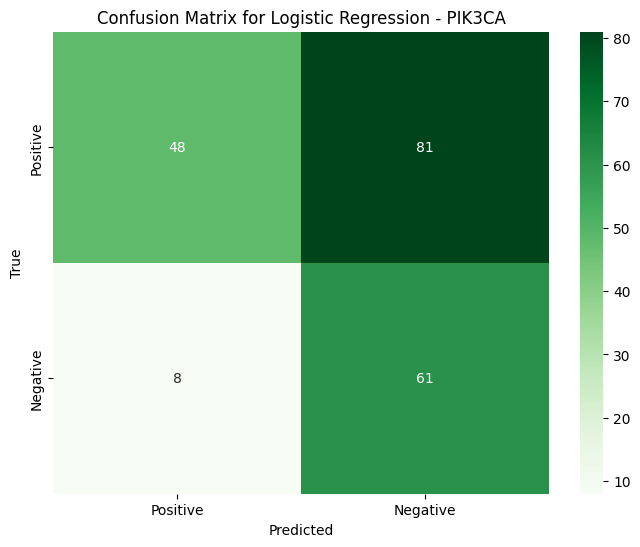

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.550505        0.429577     0.884058  0.578199  0.271005

Evaluating model: Random Forest for driver: PIK3CA
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
           Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  Random Forest     0.927856      0.929347   0.927856  0.925922  0.815377
Classification Report for Random Forest on driver PIK3CA:
              precision    recall  f1-score   support

           0       0.81      0.47      0.60       129
           1       0.45      0.80      0.57        69

    accuracy                           0.59       198
   macro avg       0.63      0.63      0.59       198
weighted avg       0.69      0.59      0.59       198



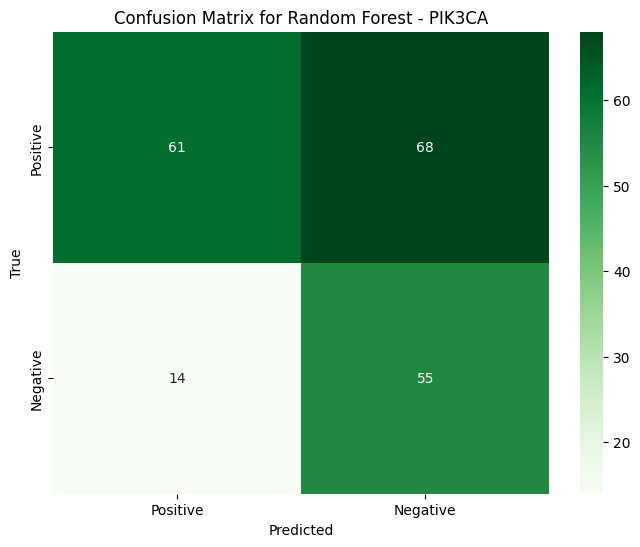

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.585859        0.447154     0.797101  0.572917  0.265186

Evaluating model: XGBoost for driver: PIK3CA


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
     Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  XGBoost     0.925189      0.926534   0.925189  0.923077  0.808721
Classification Report for XGBoost on driver PIK3CA:
              precision    recall  f1-score   support

           0       0.81      0.52      0.63       129
           1       0.46      0.77      0.58        69

    accuracy                           0.61       198
   macro avg       0.63      0.64      0.60       198
weighted avg       0.69      0.61      0.61       198



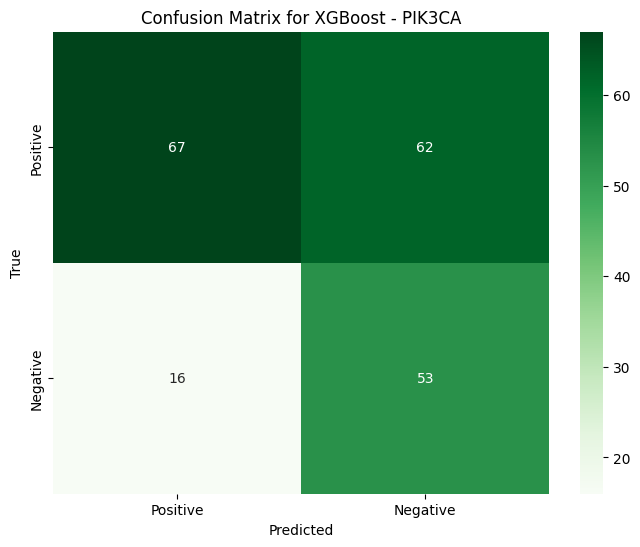

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.606061         0.46087     0.768116  0.576087  0.277628

Processing driver: TP53

Evaluating model: Logistic Regression for driver: TP53


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Best Hyperparameters: {'C': 1, 'l1_ratio': 1.0, 'penalty': 'elasticnet', 'solver': 'saga'}
                 Model  CV Accuracy  CV Precision  CV Recall    CV F1  \
0  Logistic Regression     0.977464      0.977507   0.977464  0.97745   

     CV MCC  
0  0.953237  
Classification Report for Logistic Regression on driver TP53:
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       132
           1       0.62      0.79      0.69        66

    accuracy                           0.77       198
   macro avg       0.75      0.77      0.75       198
weighted avg       0.79      0.77      0.77       198



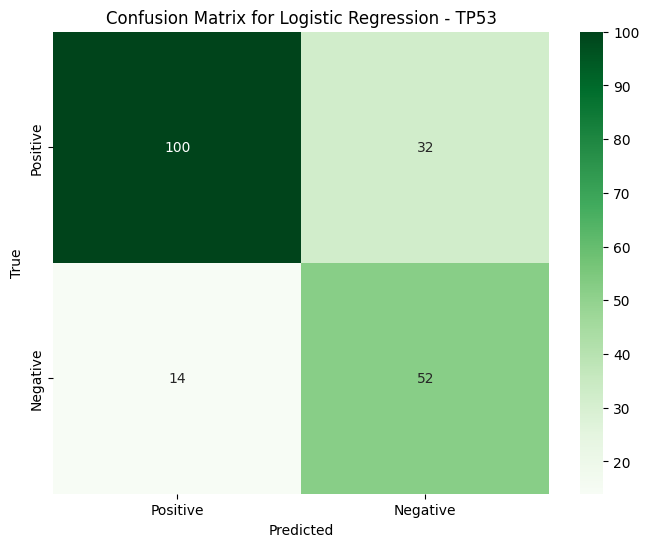

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.767677        0.619048     0.787879  0.693333  0.520266

Evaluating model: Random Forest for driver: TP53
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
           Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  Random Forest     0.954929      0.955703   0.954929  0.954677  0.906791
Classification Report for Random Forest on driver TP53:
              precision    recall  f1-score   support

           0       0.87      0.83      0.84       132
           1       0.68      0.74      0.71        66

    accuracy                           0.80       198
   macro avg       0.77      0.78      0.78       198
weighted avg       0.80      0.80      0.80       198



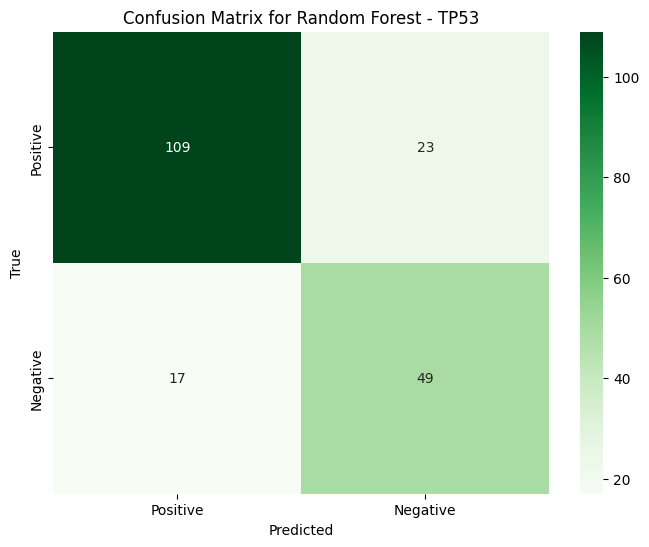

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0        0.79798        0.680556     0.742424  0.710145  0.556794

Evaluating model: XGBoost for driver: TP53


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
     Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  XGBoost     0.964327      0.964507   0.964327  0.964223  0.925918
Classification Report for XGBoost on driver TP53:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       132
           1       0.63      0.79      0.70        66

    accuracy                           0.77       198
   macro avg       0.75      0.78      0.76       198
weighted avg       0.79      0.77      0.78       198



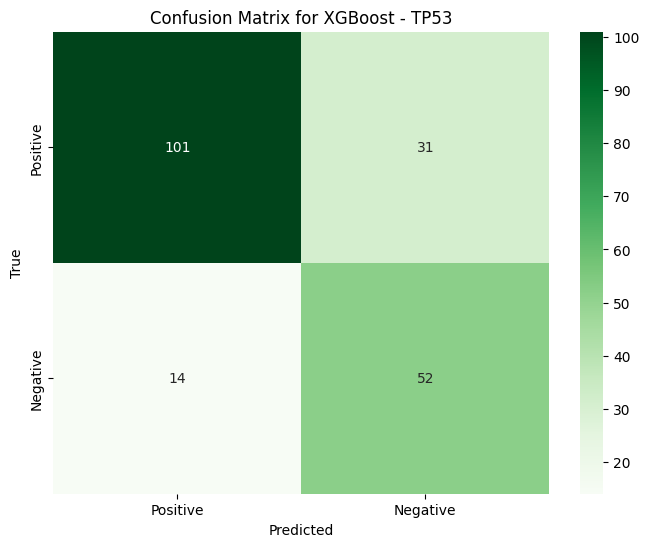

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.772727        0.626506     0.787879  0.697987  0.528348

Processing driver: CDH1

Evaluating model: Logistic Regression for driver: CDH1
Best Hyperparameters: {'C': 10, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}
                 Model  CV Accuracy  CV Precision  CV Recall    CV F1  \
0  Logistic Regression     0.821108      0.822709   0.821108  0.81614   

     CV MCC  
0  0.608264  
Classification Report for Logistic Regression on driver CDH1:
              precision    recall  f1-score   support

           0       0.96      0.53      0.69       172
           1       0.22      0.85      0.34        26

    accuracy                           0.58       198
   macro avg       0.59      0.69      0.52       198
weighted avg       0.86      0.58      0.64       198



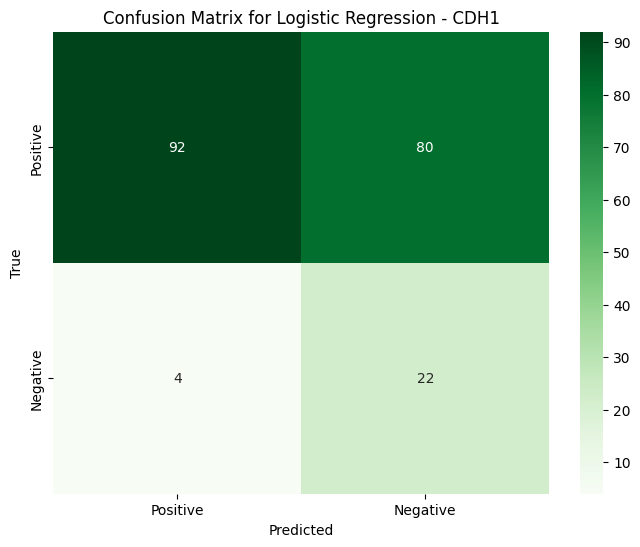

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall  Test F1  Test MCC
0       0.575758        0.215686     0.846154  0.34375  0.257503

Evaluating model: Random Forest for driver: CDH1
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
           Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  Random Forest     0.942051      0.944251   0.942051  0.941181  0.876051
Classification Report for Random Forest on driver CDH1:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81       172
           1       0.27      0.73      0.40        26

    accuracy                           0.71       198
   macro avg       0.61      0.72      0.60       198
weighted avg       0.86      0.71      0.75       198



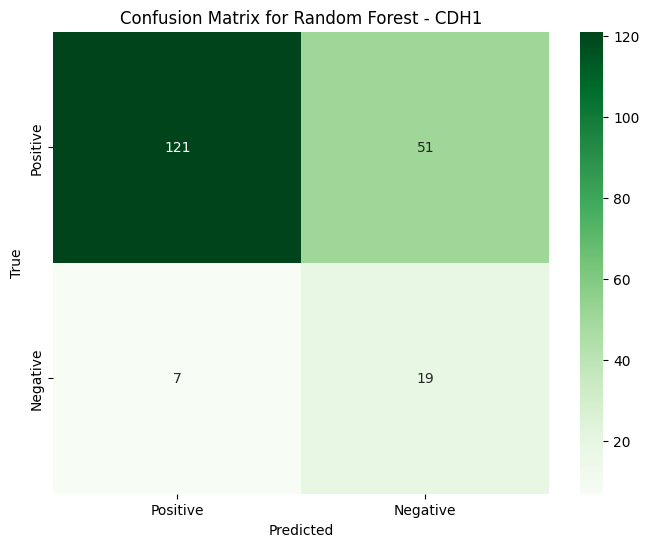

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.707071        0.271429     0.730769  0.395833  0.306792

Evaluating model: XGBoost for driver: CDH1


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
     Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  XGBoost     0.953664        0.9556   0.953664  0.953052  0.901194
Classification Report for XGBoost on driver CDH1:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       172
           1       0.24      0.65      0.35        26

    accuracy                           0.69       198
   macro avg       0.59      0.67      0.57       198
weighted avg       0.84      0.69      0.74       198



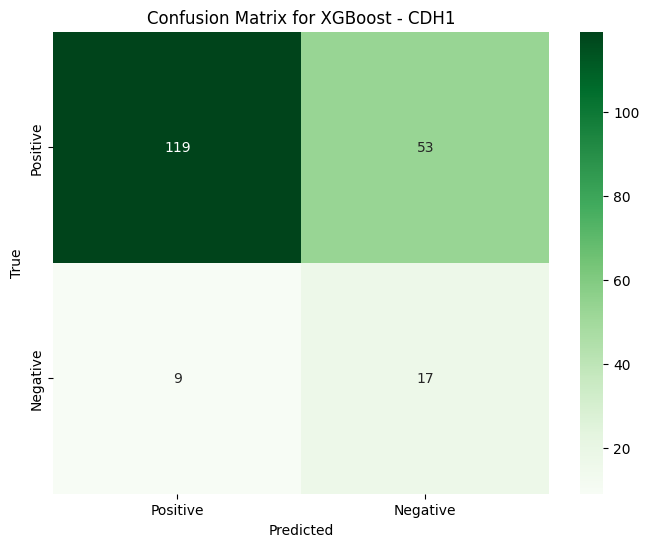

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.686869        0.242857     0.653846  0.354167  0.244233

Processing driver: GATA3

Evaluating model: Logistic Regression for driver: GATA3
Best Hyperparameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}
                 Model  CV Accuracy  CV Precision  CV Recall     CV F1  \
0  Logistic Regression     0.851584      0.853015   0.851584  0.848137   

     CV MCC  
0  0.676569  
Classification Report for Logistic Regression on driver GATA3:
              precision    recall  f1-score   support

           0       0.95      0.45      0.61       174
           1       0.17      0.83      0.29        24

    accuracy                           0.49       198
   macro avg       0.56      0.64      0.45       198
weighted avg       0.86      0.49      0.57       198



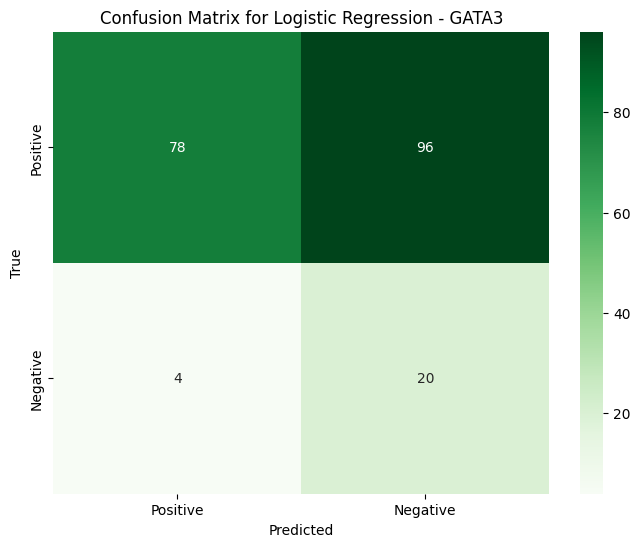

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.494949        0.172414     0.833333  0.285714  0.186591

Evaluating model: Random Forest for driver: GATA3
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
           Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  Random Forest     0.961328       0.96246   0.961328  0.960968  0.917393
Classification Report for Random Forest on driver GATA3:
              precision    recall  f1-score   support

           0       0.92      0.66      0.77       174
           1       0.19      0.58      0.29        24

    accuracy                           0.65       198
   macro avg       0.55      0.62      0.53       198
weighted avg       0.83      0.65      0.71       198



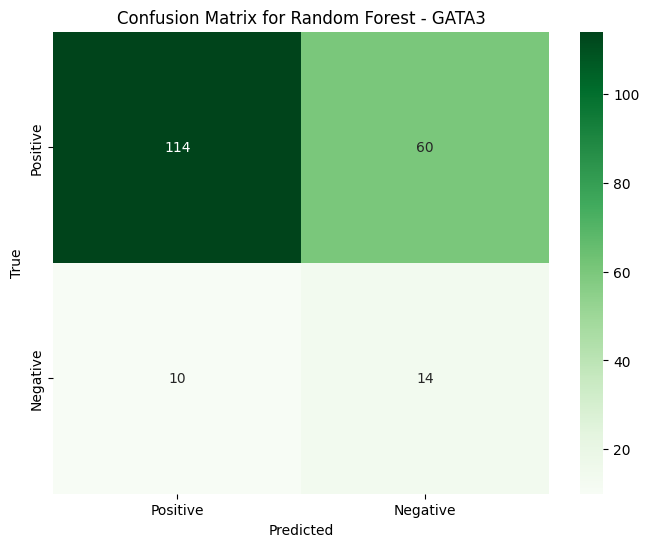

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.646465        0.189189     0.583333  0.285714  0.160899

Evaluating model: XGBoost for driver: GATA3
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}
     Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  XGBoost      0.95757      0.958825    0.95757  0.957092  0.909273
Classification Report for XGBoost on driver GATA3:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78       174
           1       0.24      0.79      0.37        24

    accuracy                           0.68       198
   macro avg       0.60      0.73      0.58       198
weighted avg       0.87      0.68      0.73       198



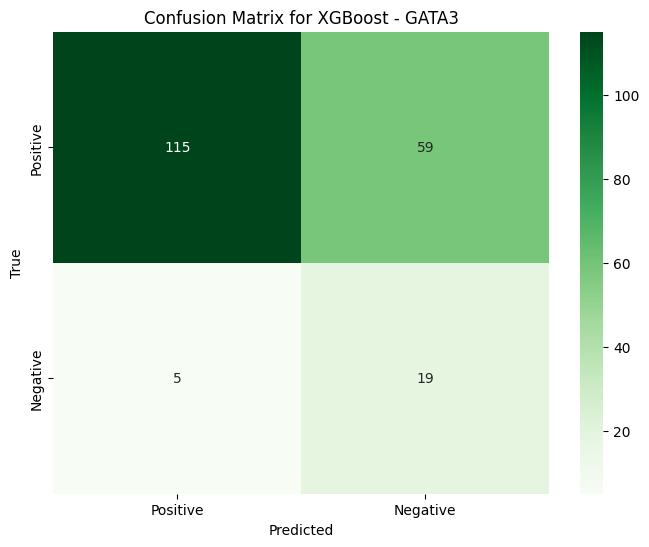

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.676768         0.24359     0.791667  0.372549  0.302304



In [23]:
# Preprocess the data for each driver
for driver, combined_df in driver_combined_dfs.items():
    print(f"Processing driver: {driver}")
    
    # Preprocess data
    preprocessed_data = preprocess_data(combined_df)
    
    # Store the preprocessed data in the results dictionary
    results[driver] = preprocessed_data
    
    # Evaluate the models on the preprocessed data
    model_results = evaluate_models(driver, preprocessed_data, models_and_params)
    
    # Store the model results in the results dictionary
    results[driver]['model_results'] = model_results

    print("\n" + "="*50)  # Separator between drivers
